# 1) Setup

In [1]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm

import numpy as np
import math
import scipy as sp
from scipy.stats import kstest
from copy import copy

import pymongo
from pymongo import MongoClient
from datetime import datetime
print("done")

done


In [2]:
#import functions from python files

#1) data import & filtering
from get_data import *
from filter_data import *
from select_data import *

#2) Frequentist
from Gaussian import *
from Gaussian_ml import *
from Gaussian_freq import *

from update_mean import *
from update_var import *
from Gaussian_freq_update import *

#3) Bayesian: uni-parameter
from Gaussian_bayes import *
from Gaussian_bayes_update import *

#4) Bayesian: multi-parameter
from Gamma import *
from Gaussian_broadcast import *
from Normal_Gamma import *
from Normal_Gamma_bayes import *
from Normal_Gamma_bayes_update import *

#5) Stats tests
from error_mae import *
from error_mse import *
from integrate_pdf import *

from error_ks import *                 #Kolmogorov-Smirnov
from error_ks_2samples import *
from error_cvm import *                #Cramer-von Mises
from error_cvm_2samples import *

from Gaussian_log_likelihood import *
from error_aic import *                #Akaike Information Criterion
from error_bic import *                #Bayesian Information Criterion

#6) Other distributions
from Lognormal import *




print("done")

done


In [3]:
#1) Import data from PyMongo
df = get_data()
#2) Preliminary filtering
df = filter_data(df)
#3) Select data of interest
df = select_data(df, wp1 = "WayPoint69", wp2 = "WayPoint70")
df.head(2)

,edge_id,operation_time
345,WayPoint69_WayPoint70,10.328
353,WayPoint69_WayPoint70,12.461


# 2) Frequentist Approach

## 2a) Frequentist: Gaussian, all-at-once

MLE mean: 12.762135135135134     MLE var: 13.107016549306062


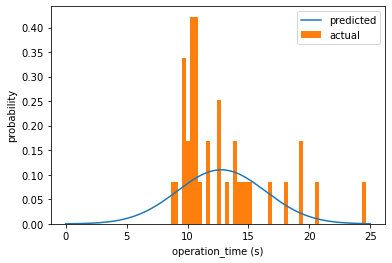

In [4]:
#separate out a subset of the data
t_op = df["operation_time"]
n_terms = len(t_op)//20
t_obs = t_op[0:n_terms]

# Frequentist MLE estimate using data in subset
t, p, mean_ml, var_ml = Gaussian_freq(t_obs)
print("MLE mean:",mean_ml, "    MLE var:", var_ml)

## 2b) Frequentist: Gaussian, sequential updates

12.154848202396819
MLE mean: 12.154848202396819     MLE var: 11.378789733357094


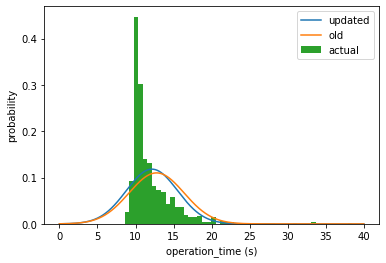

In [5]:
#seperate out new observations 
t_op = df["operation_time"]
t_obs = t_op[n_terms:]

#Update Frequentist MLE with new observations
t, p, mean_ml, var_ml = Gaussian_freq_update(mean_ml,var_ml,n_terms,t_obs)
print("MLE mean:",mean_ml, "    MLE var:", var_ml)
plt.hist(t_obs, density = True, bins = 50)
plt.legend(["updated","old","actual"])

# 3) Bayesian Approach: uni-parameter

## 3a) Gaussian Conjugate Prior
 - mean unknown, variance known

12.709


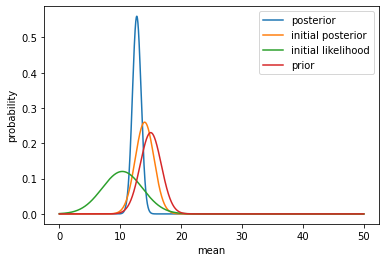

In [6]:
#separate out a subset of the data
t_op = df["operation_time"]
#n_terms = 1 if you want just the initial estimates
n_terms = len(t_op)//40       
t_obs = t_op[0:n_terms]

#define parameters
mean_0 = 15
var_0 = 3
var = 11

# sequential Bayesian updates to find MAP estimate of mean
mean_test, posterior, mean_map = Gaussian_bayes(t_obs, mean_0, var_0, var)
print(mean_map)

#store mean_map for comparison
mean_map_old = mean_map

Text(0.5, 1.0, 'WayPoint69_WayPoint70')

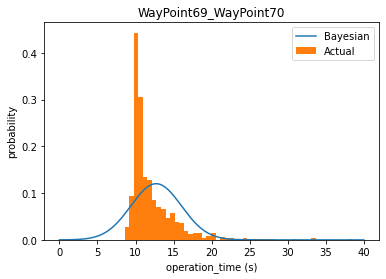

In [7]:
#Plot against actual data

#independent variable to plot over
t_op = df["operation_time"]
t_start= 0.01
t_stop = (np.max(t_op)//5)*5 + 5    #round up to nearest 5 secs
t_step = 0.01
t_test = np.arange(t_start,t_stop,t_step)

#Duration distribution using MAP parameters from Bayesian method
p_bayes = Gaussian(t_test,mean_map,var)

#plot
plt.plot(t_test,p_bayes)

plt.hist(t_op, density = True, bins = 50)
plt.legend(["Bayesian", "Actual"])
plt.xlabel("operation_time (s)")
plt.ylabel("probability")
plt.title(df.iloc[0,0])


## 3b) Update posterior with new observations
 - mean unknown, variance known
 - You should run 3a) before running 3b)

12.468


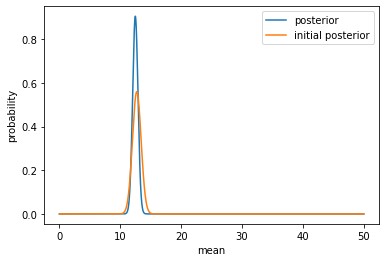

In [8]:
#separate out a subset of the data
t_op = df["operation_time"]
#n_terms = 1 if you want just the initial estimates
n_terms = len(t_op)//40       
t_obs = t_op[n_terms:3*n_terms]

# sequential Bayesian updates to find MAP estimate of mean
mean_test, posterior, mean_map = Gaussian_bayes_update(mean_test, posterior, t_obs, var = 11, threshold = 0.9)
print(mean_map)

Text(0.5, 1.0, 'WayPoint69_WayPoint70')

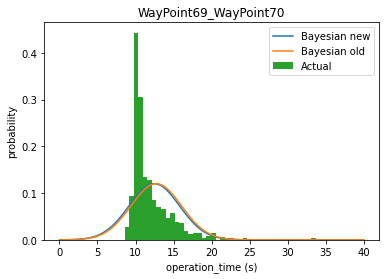

In [9]:
#Plot against actual data

#independent variable to plot over
t_op = df["operation_time"]
t_start= 0.01
t_stop = (np.max(t_op)//5)*5 + 5    #round up to nearest 5 secs
t_step = 0.01
t_test = np.arange(t_start,t_stop,t_step)

#Duration distribution using MAP parameters from Bayesian method
p_bayes = Gaussian(t_test,mean_map,var)
p_bayes_old = Gaussian(t_test,mean_map_old,var)   #for comparison

#plot
plt.plot(t_test,p_bayes)
plt.plot(t_test,p_bayes_old)        #for comparison

plt.hist(t_op, density = True, bins = 50)
plt.legend(["Bayesian new","Bayesian old", "Actual"])
plt.xlabel("operation_time (s)")
plt.ylabel("probability")
plt.title(df.iloc[0,0])

# 4) Bayesian Approach: multi-parameter
- unknown mean & variance

## 4a) Normal-Gamma Conjugate Prior
- 2 parameters
- unknown mean & var

MAP mean: 12.0     MAP var: 8.7


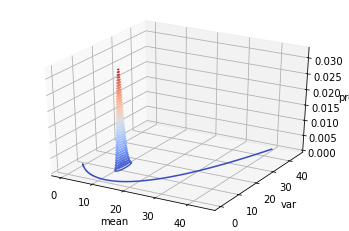

In [5]:
#separate out a subset of the data
t_op = df["operation_time"]
#n_terms = 1 if you want just the initial estimates
n_terms = len(t_op)//10     
t_obs = t_op[0:n_terms]


#set parameters
mu_0 = 10
beta = 5
a = 1
b = 2

#Bayesian MAP estimate of mean & variance of Gaussian distribution
mean_test, var_test, posterior, mean_map, var_map = Normal_Gamma_bayes(t_obs, mu_0, beta, a, b)
print("MAP mean:", mean_map, "    MAP var:", var_map)

#store mean_map & mean_var for comparison
mean_map_old = mean_map
var_map_old = var_map

Text(0.5, 1.0, 'WayPoint69_WayPoint70')

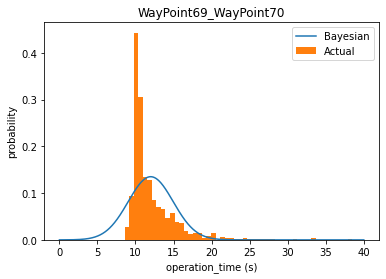

In [6]:
#Plot against actual data

#independent variable to plot over
t_op = df["operation_time"]
t_start= 0.01
t_stop = (np.max(t_op)//5)*5 + 5    #round up to nearest 5 secs
t_step = 0.01
t_test = np.arange(t_start,t_stop,t_step)

#Duration distribution using MAP parameters from Bayesian method
p_bayes = Gaussian(t_test,mean_map,var_map)

#plot
plt.plot(t_test,p_bayes)

plt.hist(t_op, density = True, bins = 50)
plt.legend(["Bayesian", "Actual"])
plt.xlabel("operation_time (s)")
plt.ylabel("probability")
plt.title(df.iloc[0,0])

## 4b) Update posterior with new observations

MAP mean: 12.3     MAP var: 11.0


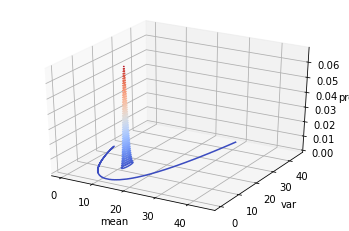

In [7]:
#separate out a subset of the data
t_op = df["operation_time"]
#n_terms = 1 if you want just the initial estimates
n_terms = len(t_op)//10      
t_obs = t_op[n_terms:3*n_terms]

#sequential MAP updates
mean_test, var_test, posterior, mean_map, var_map = Normal_Gamma_bayes_update(mean_test, var_test, posterior, t_obs)
print("MAP mean:", mean_map, "    MAP var:", var_map)


Text(0.5, 1.0, 'WayPoint69_WayPoint70')

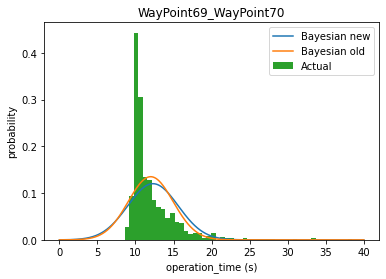

In [8]:
#Plot against actual data

#independent variable to plot over
t_op = df["operation_time"]
t_start= 0.01
t_stop = (np.max(t_op)//5)*5 + 5    #round up to nearest 5 secs
t_step = 0.01
t_test = np.arange(t_start,t_stop,t_step)

#Duration distribution using MAP parameters from Bayesian method
p_bayes = Gaussian(t_test,mean_map,var_map)
p_bayes_old = Gaussian(t_test,mean_map_old,var_map_old)   #for comparison

#plot
plt.plot(t_test,p_bayes)
plt.plot(t_test,p_bayes_old)        #for comparison

plt.hist(t_op, density = True, bins = 50)
plt.legend(["Bayesian new","Bayesian old", "Actual"])
plt.xlabel("operation_time (s)")
plt.ylabel("probability")
plt.title(df.iloc[0,0])

# 5) Goodness-of-fit

## 5ai) Mean Absolute Error (MAE) 
- between predicted distribution and histogram

In [14]:
#compare to the exact predicted distribution (Gaussian)
mae = error_mae(t_test, p_bayes, t_obs, bin_width = 20)
print(mae)

0.022339017116778468


## 5aii) Mean Squared Error (MSE)

In [15]:
#compare to the exact predicted distribution (Gaussian)
mse = error_mse(t_test, p_bayes, t_obs, bin_width = 20)
print(mse)

0.0030040637445346895


## 5bi) Kolmogorov-Smirnov (K-S) Test
- The K-S statistic (D) is the **supremum (Least Upper Bound - i.e. maximum) of distances between the empirical CDF of the observations and CDF of the predicted distribution**
- Null hypothesis is that the observations are drawn from the predicted distribution
- Low D (distance) & high p-value is good


- Less powerful than Anderson-Darling, Shapiro-Wilk
- Refinements of K-S include Anderson-Darling & Cramer Von-Mises

0.16428637371971877


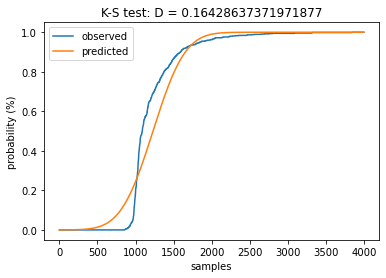

In [16]:
#compare to the exact predicted distribution (Gaussian)
D = error_ks(t_test, p_bayes, t_op)
print(D)

Text(0, 0.5, 'Probability')

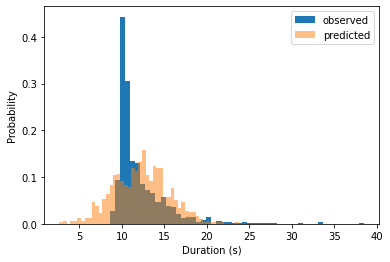

In [17]:
#plot Gaussian model vs actual data
plt.hist(t_op, density = True, bins = 50)
plt.hist(np.random.normal(mean_map,var_map**0.5,len(t_op)), density = True, bins = 50, alpha = 0.5)
plt.legend(["observed", "predicted"])
plt.xlabel("Duration (s)")
plt.ylabel("Probability")

## 5bii) ~~Anderson-Darling (AD) Test~~
- Quadratic EDF statistic with **weight function = 1/ (cdf_value * (1-cdf_value))**
- **A^2 = integral ( weight_function * (distance of edf to cdf)^2 ) * n_sample**
- Places more weight on observations in the tails of the distribution

## 5biii) Cramer Von-Mises (CVM) Test
- Quadratic EDF statistic with weight function = 1 
- **w^2 = integral ( (distance of edf to cdf)^2 )**

Note: 
- for error_cvm, CVM statistics should be calculated with same t_pred in order to be directly compared
- for error_cvm_2samples, CVM statistics should be calculated with same n_bins & t_max in order to be directly compared
- CVM statistics calculated from error_cvm & error_cvm_2samples should not be directly compared (unlike for Anderson-Darling statistic)

16.625321052448324


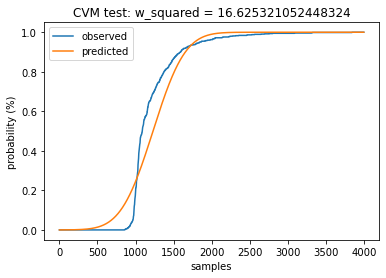

In [23]:
#CVM Test on Gaussian model
# This CANNOT be compared to the other distributions below
w_squared = error_cvm(t_test, p_bayes, t_op)
print(w_squared)

4.29840904537402


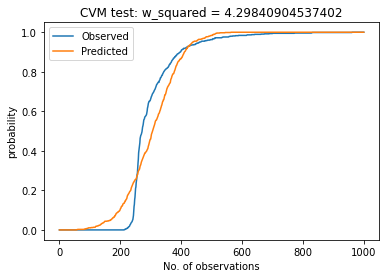

In [24]:
#CVM Test on data generated from Gaussian model with learned parameters
# This CAN be compared to the other distributions below
t_pred = np.random.normal(mean_map,var_map**0.5,len(t_op))
w_squared = error_cvm_2samples(t_op, t_pred)
print(w_squared)

## 5ci) Akaike Information Criterion (AIC)
- **AIC = 2k - 2ln(L_max)**
- k is no. of estimated parameters in model (e.g. mean_map, var_map)
- L_max is max of likelihood function p(data | params)


- The best model has the lowest AIC score (i.e. increasing estimated parameters is penalised, but we also want the highest likelihood function)
- AIC only gives **relative** performance compared to other models ==> check absolute performance of the best model

In [9]:
# AIC for Gaussian
log_likelihood = Gaussian_log_likelihood(t_op,mean_map,var_map)
params = [mean_map, var_map]
aic = error_aic(t_op, params, model = "gaussian")
print(log_likelihood, aic)

-1981.01368959977 3966.02737919954


## 5cii) Bayesian Information Criterion (BIC)
- **BIC = kln(n) - 2ln(L_max)**
- k is no. of estimated parameters in model (e.g. mean_map, var_map)
- L_max is max of likelihood function p(data | params)
- n is no. of observations


- Again, the best model has lowest BIC
- Larger penalty for overfitting (too many model parameters) compared to AIC
- Requires n >> k

In [10]:
#BIC for Gaussian
log_likelihood = Gaussian_log_likelihood(t_op,mean_map,var_map)
params = [mean_map, var_map]
bic = error_bic(t_op, params, model = "gaussian")
print(log_likelihood, bic)

-1981.01368959977 3975.2701905030685


## 5ciii) ~~Widely Applicable Information Criterion (WAIC)~~
- Also Widely Applicable Bayesian Information Criterion (WBIC)
- Can be numerically calculated without info about the distribution
- Unlike AIC, this is a Bayesian method
- However, WAIC is more computationally expensive

# 6) Other Distributions

## 6a) Lognormal

1.0471314883290266 0.707732254727055 8.414285702302994


Text(0, 0.5, 'Probability')

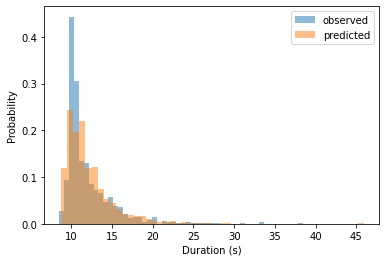

In [12]:
from scipy.stats import lognorm

#sigma = std = shape
#mu = np.log(scale)
shape, loc, scale = lognorm.fit(t_op)


mu, sigma = np.log(scale), shape
print(mu, sigma, loc)
t_pred = np.random.lognormal(mu,sigma,len(t_op)) + loc
plt.hist(t_op, density = True, bins = 50, alpha = 0.5);
plt.hist(t_pred, density = True, bins = 50, alpha = 0.5);
plt.legend(["observed", "predicted"])
plt.xlabel("Duration (s)")
plt.ylabel("Probability")


Text(0.5, 1.0, 'Lognormal')

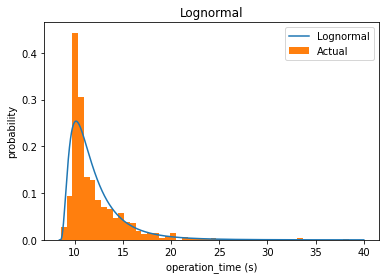

In [13]:
#use fitted parameters to plot Lognormal distribution for comparison to actual observations
p_lognormal = Lognormal(t_test,mu, sigma**2, loc)
plt.plot(t_test,p_lognormal)

plt.hist(t_op, density = True, bins = 50)
plt.legend(["Lognormal", "Actual"])
plt.xlabel("operation_time (s)")
plt.ylabel("probability")
plt.title("Lognormal")

0.11717709720372887


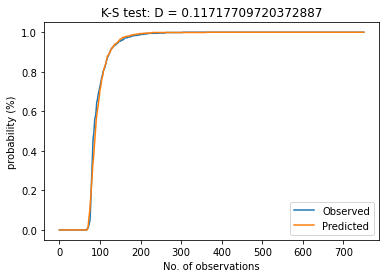

In [14]:
#K-S Test on Lognormal model
D = error_ks_2samples(t_op, t_pred)
print(D)

0.4162432726908042


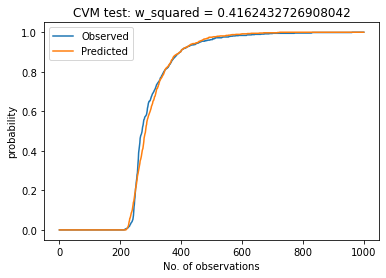

In [15]:
#CVM Test on lognormal model
w_squared = error_cvm_2samples(t_op, t_pred)
print(w_squared)

In [16]:
#AIC criterion on Lognormal model
params = [mu, sigma, loc]
aic = error_aic(t_op, params, model = "lognormal")
print(aic)

1425.2576744642088


In [17]:
#BIC criterion on Lognormal model
params = [mu, sigma, loc]
bic = error_bic(t_op, params, model = "lognormal")
print(bic)

1439.1218914195013


In [18]:
#other metrics
mae = ( 1/len(t_op) ) * np.sum( np.abs(t_op - t_pred) )
mse = ( 1/len(t_op) ) * np.sum( np.square(t_op - t_pred) )
print("MAE:", mae, "MSE:", mse)

MAE: 2.9779968594422273 MSE: 20.7533768855233


## 6b) Gamma